<h1>Demonstration of circuit import and export and printing to openqasm</h1>

<h2> Distribution Statement </h2>

DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

<br>
This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

<br>
© 2022 Massachusetts Institute of Technology.

<br>
<br>
The software/firmware is provided to you on an As-Is basis

In [1]:
###
### Imports to support the pyQSP Gate-Based Hamiltonian simulation
###
import sys
import pickle
import os
import cirq
from cirq.contrib.svg import SVGCircuit

import pyLIQTR.QSP.gen_qsp                 as qspFuncs
import pyLIQTR.QSP.QSP                     as pQSP
import pyLIQTR.sim_methods.quantum_ops  as qops        


from pyLIQTR.QSP.Hamiltonian             import Hamiltonian as pyH
from pyLIQTR.QSP.qsp_helpers             import qsp_decompose_once, print_to_openqasm, prettyprint_qsp_to_qasm
from pyLIQTR.gate_decomp.cirq_transforms import clifford_plus_t_direct_transform, parse_and_reconstruct


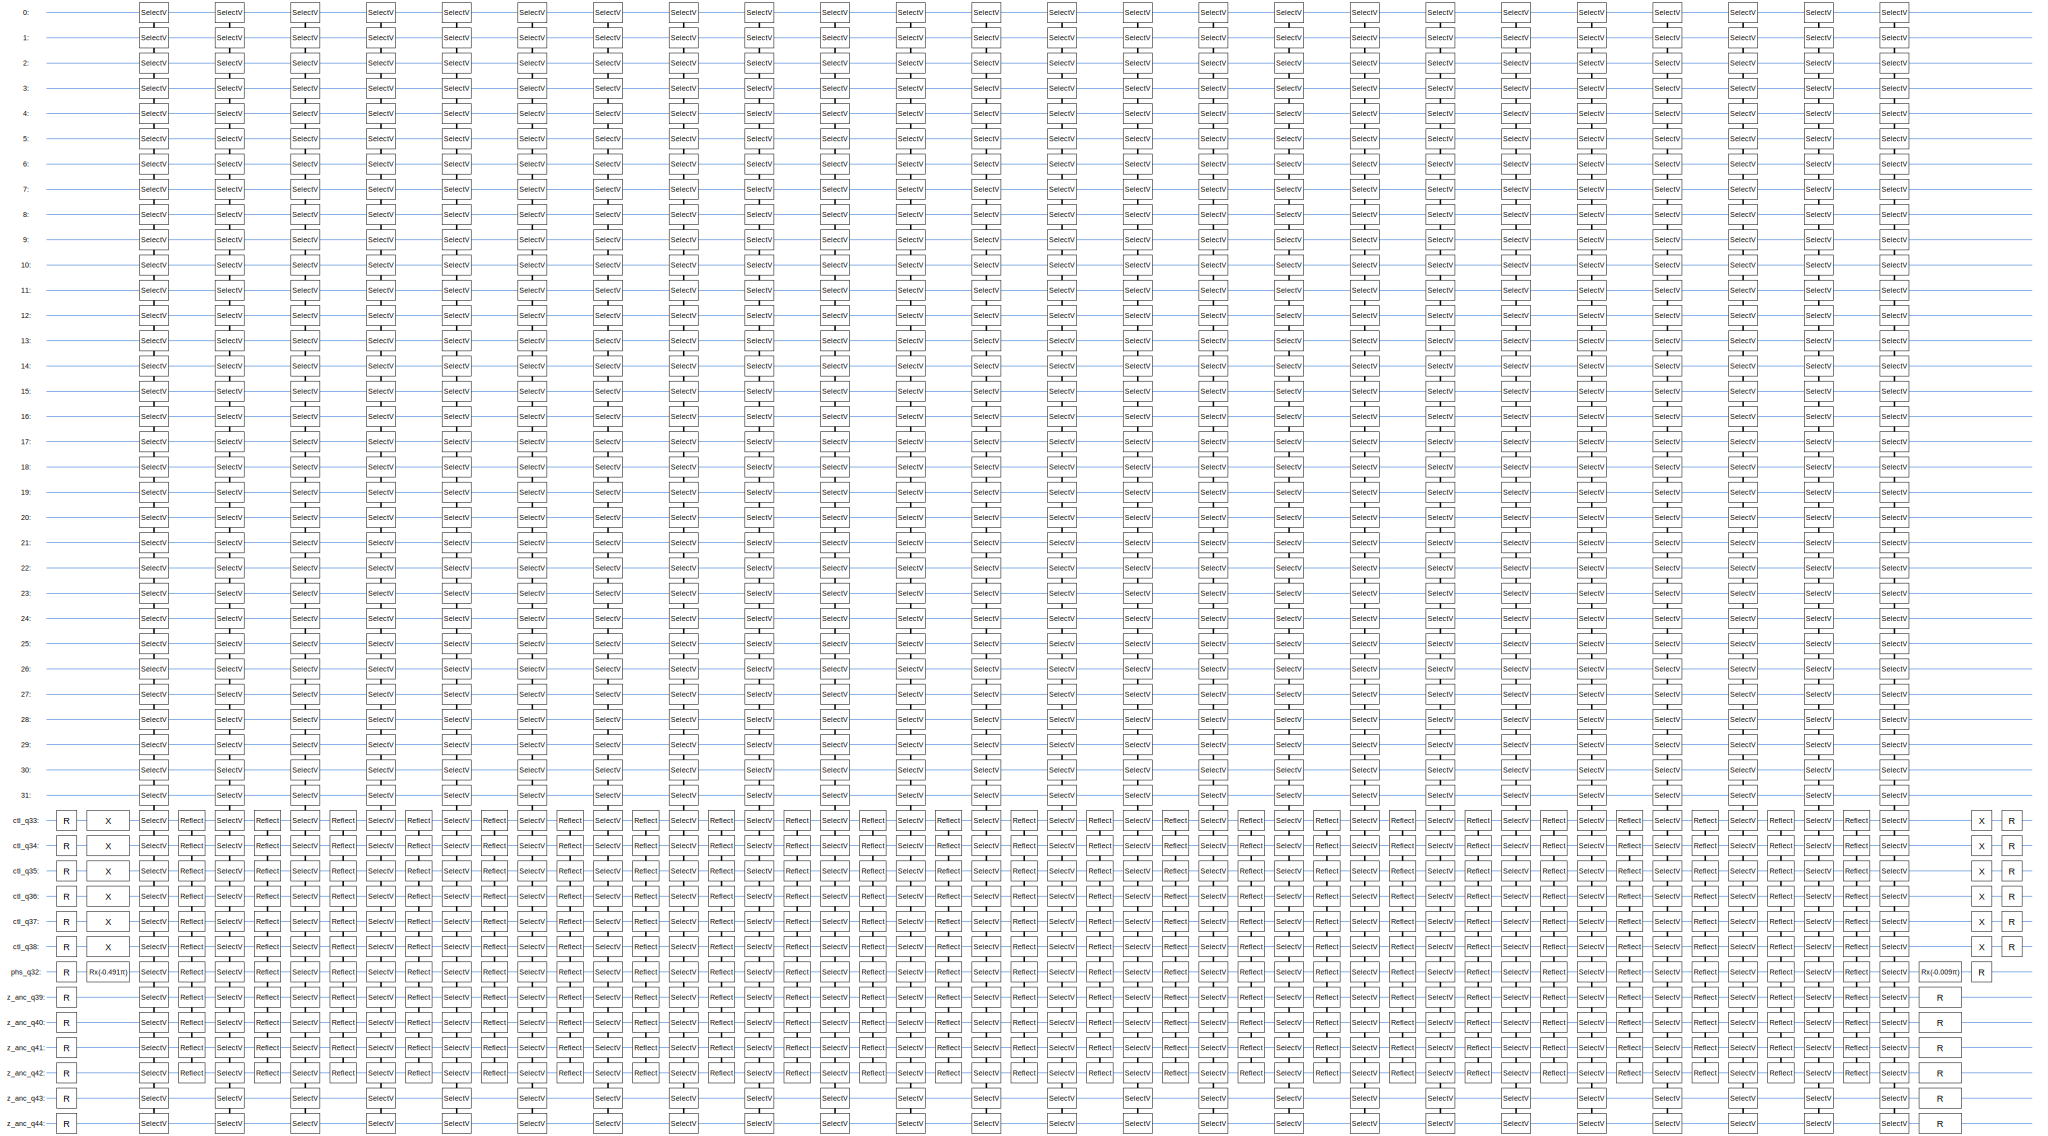

In [2]:
N    =   32;        J_z  =   1.0;          h_x  =  -1.0
tuples,types,coeffs = qops.params_heisenberg_1d(N,J_z=J_z,h_x=h_x,periodic=False)
ham_strings = qops.ps_text_full_set(tuples,types,N,Coeffs=coeffs)
required_precision   = 1e-18
timestep_of_interest = 0.05 # sim_time
qsp_H = pyH(ham_strings)
angles, tolerances = qspFuncs.compute_hamiltonian_angles(qsp_H, simtime = timestep_of_interest, req_prec=required_precision,
                                                        mode="random")
qsp_generator = pQSP.QSP(phis=angles, hamiltonian=qsp_H, target_size=qsp_H.problem_size)
qsp_circ      = qsp_generator.circuit()
SVGCircuit(qsp_circ)


This line demonstrates how one can use the python `pickle` library to save and reload circuits. Note, it is recommended that one saves the "high-level" circuit as opposed to the decomposed circuit, since this saves memory and time when saving/loading.

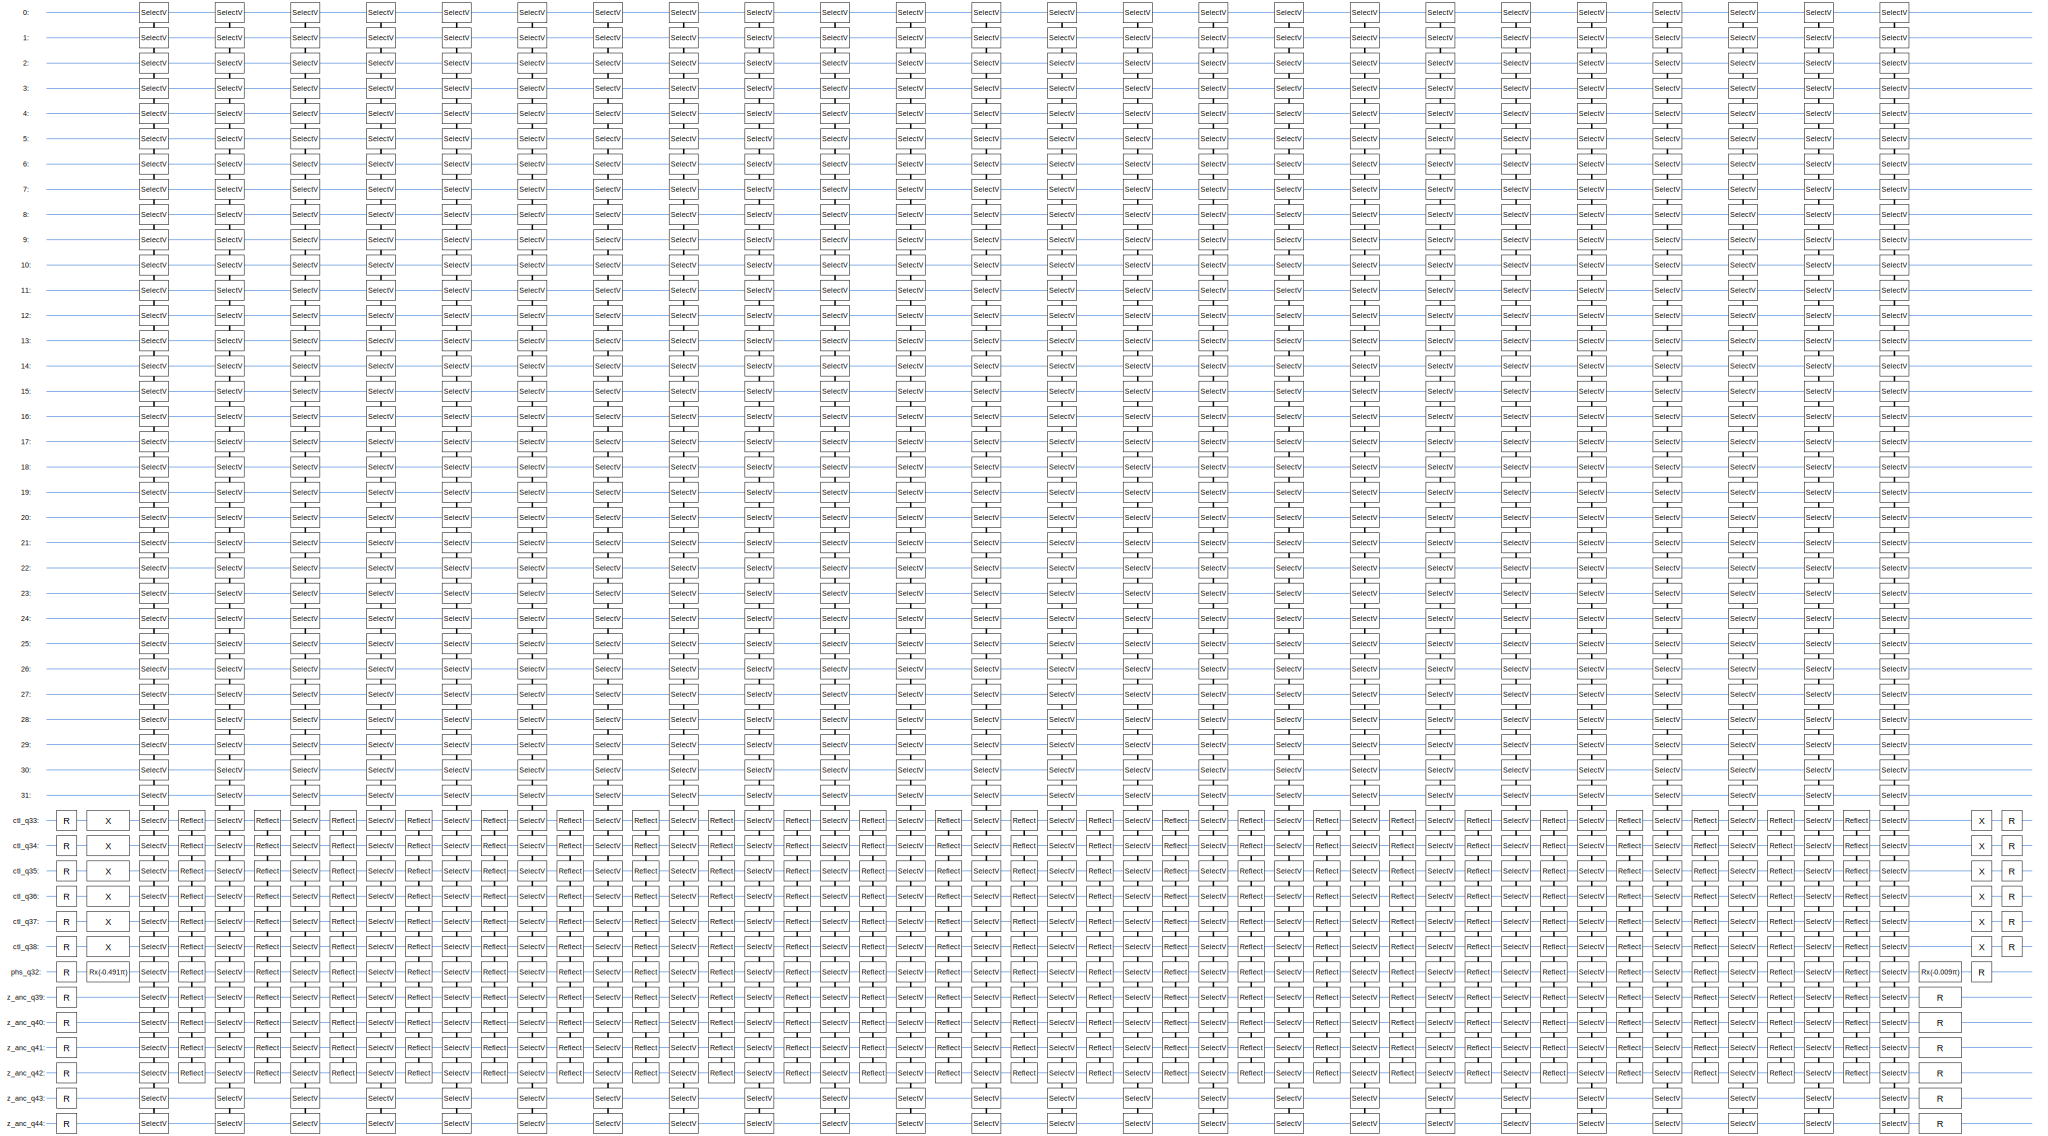

In [3]:
if os.path.exists("example_circuit.pkl"):
    os.remove("example_circuit.pkl")

#SAVE IT
with open("example_circuit.pkl","wb") as fh:
    pickle.dump(qsp_circ,fh)

#LOAD IT
with open("example_circuit.pkl","rb") as fh:
    reloaded_circuit = pickle.load(fh)

if os.path.exists("example_circuit.pkl"):
    os.remove("example_circuit.pkl")
    
#PRINT IT
SVGCircuit(reloaded_circuit)

In order to enable more scalable export of circuits to openqasm, we have made three updates (as of 2023April21).
* Printing has been optimized and changed to be "generator" based
* Clifford+T decomposition has been modified to make use of a representation outlined in https://arxiv.org/pdf/0806.3834.pdf (and further discussed in https://arxiv.org/pdf/1312.6584.pdf and http://www.cs.umd.edu/~amchilds/qa/qa.pdf, as potentially easier to digest forms)
* The introduction to the Clifford+T decomposition to return decompositions of equal length, but of random construction (this saves computation time since an accurate decomposition does not need to be calculated)

The following cells demonstrate how to make use of the new printing capability

In [4]:
#Take the circuit and fully decompose it into just gates
decomposed_once_circuit = cirq.align_left(qsp_decompose_once(qsp_circ))
fully_decomposed_circuit      = cirq.align_left(qsp_decompose_once(decomposed_once_circuit))

In [5]:
from pyLIQTR.utils.printing import to_openqasm

#This "to_openqasm" function acts as a generator on the input circuit.
#One can use this to pipe output from a python program into another tool.
for ctr,line in enumerate(to_openqasm(fully_decomposed_circuit)):
    print(line)
    if ctr > 100:
        break

// Generated from Cirq, Openfermion, and MIT LL

OPENQASM 2.0;
include "qelib1.inc";

// Qubits: [q(0), q(1), q(2), q(3), q(4), q(5), q(6), q(7), q(8), q(9), q(10), q(11), q(12), q(13), q(14), q(15), q(16), q(17), q(18), q(19), q(20), q(21), q(22), q(23), q(24), q(25), q(26), q(27), q(28), q(29), q(30), q(31), ctl_q33, ctl_q34, ctl_q35, ctl_q36, ctl_q37, ctl_q38, phs_q32, z_anc_q39, z_anc_q40, z_anc_q41, z_anc_q42, z_anc_q43, z_anc_q44]
qreg q[45];


reset q[32];



reset q[33];



reset q[34];



reset q[35];



reset q[36];



reset q[37];



reset q[38];



reset q[39];



reset q[40];



reset q[41];



reset q[42];



reset q[43];



reset q[44];



x q[32];



x q[33];



x q[34];



x q[35];



x q[36];



x q[37];



rx(pi*-0.4912057053) q[38];



reset q[39];



reset q[40];



reset q[41];



reset q[42];



reset q[43];



reset q[44];



ry(pi*0.4949472499) q[32];



cx q[32],q[33];



ry(pi*-0.0051349212) q[33];



cx q[32],q[33];



ry(pi*0.4948650788) q[33];



cx q[32],

The next set of cells demonstrates a modification to `clifford_plus_t_direct_transform`, which allows for a more compressed representation of the Clifford+T transform of the various rotation gates within the circuit.

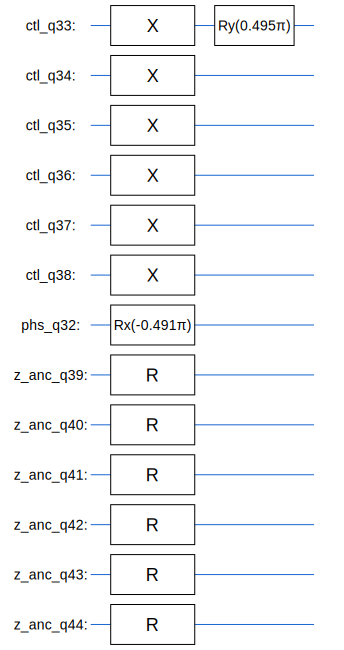

In [6]:
#Let's just grab a slice of the circuit, and we see that in addition to the X+Reset gates,
# we see the two types of rotation gates.
SVGCircuit(fully_decomposed_circuit[1:3])

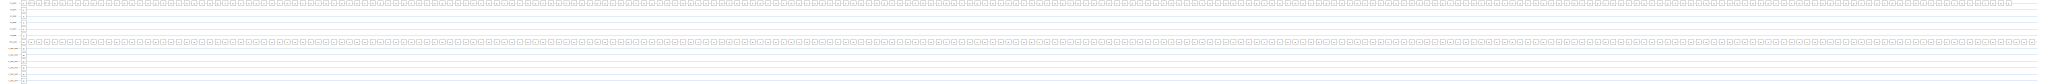

In [7]:
#We see the decomposition has a large collection of gates
cliff_plus_T_circuit1    = cirq.align_left(clifford_plus_t_direct_transform(fully_decomposed_circuit[1:3]))
SVGCircuit(cliff_plus_T_circuit1)

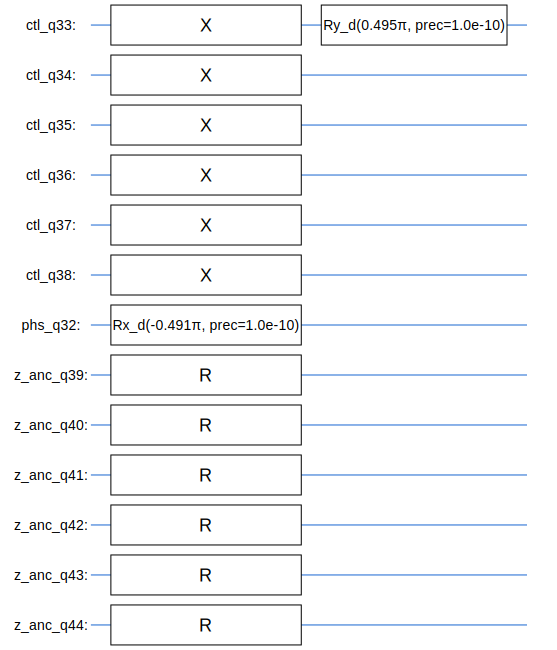

In [8]:
#We can instead modify this circuit to use pyLIQTR's "rotation-decomp" gates
#Which results in a much more compressed representation.
cliff_plus_T_circuit2    = cirq.align_left(clifford_plus_t_direct_transform(\
                                        fully_decomposed_circuit[1:3],use_rotation_decomp_gates=True))
SVGCircuit(cliff_plus_T_circuit2)

Printing the standard decomposition results in two rotation gates at this precision requiring ~500 gates

In [9]:
for ctr,line in enumerate(to_openqasm(cliff_plus_T_circuit1)):
    print(line.strip())
print("~~~~")
print("Final count : {}".format(ctr))
print("~~~~")

// Generated from Cirq, Openfermion, and MIT LL

OPENQASM 2.0;
include "qelib1.inc";

// Qubits: [ctl_q33, ctl_q34, ctl_q35, ctl_q36, ctl_q37, ctl_q38, phs_q32, z_anc_q39, z_anc_q40, z_anc_q41, z_anc_q42, z_anc_q43, z_anc_q44]
qreg q[13];
x q[0];

x q[1];

x q[2];

x q[3];

x q[4];

x q[5];

h q[6];

reset q[7];

reset q[8];

reset q[9];

reset q[10];

reset q[11];

reset q[12];

sdg q[6];

sdg q[0];

h q[6];

h q[0];

z q[6];

s q[0];

t q[6];

h q[0];

h q[6];

z q[0];

t q[6];

t q[0];

h q[6];

h q[0];

s q[6];

t q[0];

t q[6];

h q[0];

h q[6];

s q[0];

t q[6];

t q[0];

h q[6];

h q[0];

s q[6];

s q[0];

t q[6];

t q[0];

h q[6];

h q[0];

s q[6];

t q[0];

t q[6];

h q[0];

h q[6];

t q[0];

s q[6];

h q[0];

t q[6];

s q[0];

h q[6];

t q[0];

t q[6];

h q[0];

h q[6];

t q[0];

s q[6];

h q[0];

t q[6];

t q[0];

h q[6];

h q[0];

s q[6];

s q[0];

t q[6];

t q[0];

h q[6];

h q[0];

s q[6];

s q[0];

t q[6];

t q[0];

h q[6];

h q[0];

s q[6];

s q[0];

t q[6];

t q[0];

h

Printing the standard decomposition results in two rotation gates being printed as an rx_d/ry_d/rz_d gate, followed by a line of the form:
```
// (leading_T, gate_sequence, sequence_length, clifford_part)
```
* `leading_T` : A bool indicating whether or not there is a `T` gate at the start of the sequence
* `gate_sequence`: An int whose binary representation encodes a sequence of `H`, `S`, and `T` gates
* `sequence_length`: The number of `T` gates in the sequence (note if `leading_T` is true, the total number of gates is `sequence_length+1`)
* `clifford_part`: A List[str] of clifford gates that come at the end of the H,S,T sequence.

In [10]:
#An example of the compressed printing
for ctr,line in enumerate(to_openqasm(cliff_plus_T_circuit2)):
    print(line.strip())
print("~~~~")
print("Final count : {}".format(ctr))
print("~~~~")

// Generated from Cirq, Openfermion, and MIT LL

OPENQASM 2.0;
include "qelib1.inc";

// Qubits: [ctl_q33, ctl_q34, ctl_q35, ctl_q36, ctl_q37, ctl_q38, phs_q32, z_anc_q39, z_anc_q40, z_anc_q41, z_anc_q42, z_anc_q43, z_anc_q44]
qreg q[13];
x q[0];

x q[1];

x q[2];

x q[3];

x q[4];

x q[5];

h q[6];
rz_d(pi*-0.6273959955) q[6];
// (True, 309152579261942231275141931385, 101, [Z])
h q[6];
reset q[7];

reset q[8];

reset q[9];

reset q[10];

reset q[11];

reset q[12];

sdg q[0];
h q[0];
rz_d(pi*0.4949472499) q[0];
// (False, 8417961285792066796195213094, 96, [S, H, Z])
h q[0];
s q[0];
~~~~
Final count : 34
~~~~


In [13]:
#And how to reconstruct it using a provided pyLIQTR function
doReconstruct = False
qubit = None
for ctr,line in enumerate(to_openqasm(cliff_plus_T_circuit2)):
    if "rx_d" in line or "ry_d" in line or "rz_d" in line:
        print(line)
        doReconstruct=True
        qubit = line.split(" ")[1]
        continue
        
    if doReconstruct:
        gates = parse_and_reconstruct(line)
        print("Apply {}\n\t to {}".format(gates,qubit))
        qubit = None
        doReconstruct = False

print("~~~~")
print("Final count : {}".format(ctr))
print("~~~~")

rz_d(pi*-0.6273959955) q[6];

['True', '309152579261942231275141931385', '101', 'Z\n']
Apply [cirq.Z, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.T, cirq.H, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.T, cirq.H, cirq.T, cirq.H, cirq.T, cirq.H, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.T, cirq.H, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.T, cirq.H, cirq.T, cirq.H, cirq.T, cirq.H, cirq.T, cirq.H, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.T, cirq.H, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.T, cirq.H, cirq.T, cirq.H, cirq.S, cirq.T, cirq.H, cirq.S, cirq.T, ci

Finally, we can demonstrate the improvement in decomposition time when making use of these features.

In [12]:
import time
t0 = time.time()
cirq.align_left(clifford_plus_t_direct_transform(\
                                        fully_decomposed_circuit,use_rotation_decomp_gates=False,\
                                                use_random_decomp=False))
t1 = time.time()
cirq.align_left(clifford_plus_t_direct_transform(\
                                        fully_decomposed_circuit,use_rotation_decomp_gates=True,\
                                                use_random_decomp=False))
t2 = time.time()
cirq.align_left(clifford_plus_t_direct_transform(\
                                        fully_decomposed_circuit,use_rotation_decomp_gates=True,\
                                                use_random_decomp=True))
t3 = time.time()


print("Accurate decomposition took {}s, without decomp gates".format(t1-t0))
print("Accurate decomposition took {}s, with decomp gates".format(t2-t1))
print("Random decomposition took {}s, with decomp gates".format(t3-t2))

Accurate decomposition took 31.56293225288391s, without decomp gates
Accurate decomposition took 4.399601936340332s, with decomp gates
Random decomposition took 5.516552925109863s, with decomp gates
